In [3]:
%load_ext autoreload
%autoreload 2

In [40]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def load_npy_image(file_path):
    """Load a .npy image file."""
    try:
        return np.load(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None  # Return None if loading fails

def resize_image(image, size=(224, 224)):
    """Resize an image to a given size."""
    resized_image = tf.image.resize(image, size)
    return resized_image.numpy()  # Convert to NumPy array after resizing

def normalize_image(image):
    """Normalize image values to range [0, 1]."""
    if image is not None:
        return image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    return None

def load_and_preprocess_images(data_dir, num_samples=5):
    """Load and preprocess images for the inpainting task."""
    masked_files = sorted(
        [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith("masked_")]
    )
    
    images = []
    for i, file_path in enumerate(masked_files[:num_samples]):
        img = load_npy_image(file_path)
        print(img.shape)
        if img is not None:
            img = resize_image(img)
            img = normalize_image(img)
            images.append(img)
            # Check dimensions for compatibility
            check_image_dimensions(img)
        else:
            print(f"Skipping {file_path} due to loading error.")

    return images

def check_image_dimensions(image):
    """Check if the image has the correct dimensions."""
    if image.ndim != 3 or image.shape[-1] != 3:
        raise ValueError(f"Image dimensions are not compatible: {image.shape}. Expected shape: [height, width, 3]")

def display_images(images):
    """Display images in a grid."""
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


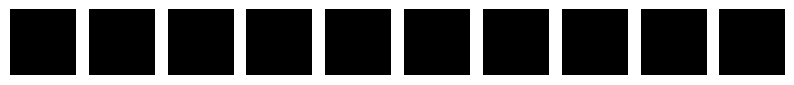

In [4]:
data_dir = r"F:\ssl_images\data\processed\coco\inpainting"  # Use raw string
images = load_and_preprocess_images(data_dir, 10)
display_images(images)


In [38]:
import tensorflow as tf
a = tf.io.read_file(r"F:\ssl_images\data\processed\coco\inpainting\masked_0.npy")


In [39]:
type(a)

tensorflow.python.framework.ops.EagerTensor

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import tensorflow as tf
from tqdm import tqdm
import sys

#sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))
from src.models.resnet import ResNet50

def load_and_preprocess_image(image_path):
    """Load and preprocess a single image for colorization."""
    # Load image
    img = np.load(image_path)
    
    # Convert to float and normalize
    img = tf.cast(img, tf.float32) / 255.0
    
    # Ensure grayscale input
    if len(img.shape) == 3 and img.shape[-1] == 3:
        img = tf.image.rgb_to_grayscale(img)
    
    # Add batch dimension
    img = tf.expand_dims(img, 0)
    
    return img

def visualize_colorization(model_path, image_path):
    """Load model, process image, and visualize results."""
    # Initialize model
    model = ResNet50((224, 224, 1))
    
    # Load trained weights
    model.load_weights(model_path)
    
    # Load and preprocess input image
    input_image = load_and_preprocess_image(image_path)
    
    # Get model prediction
    predicted_color = model.predict(input_image)
    
    # Remove batch dimension
    input_image = tf.squeeze(input_image)
    predicted_color = tf.squeeze(predicted_color) * 255.0
    
    # Load original color image for comparison
    color_path = image_path.replace('gray', 'color')
    original_color = np.load(color_path)
    original_color = original_color.astype(np.float32) #/ 255.0
    
    # Create figure with three subplots
    plt.figure(figsize=(15, 5))
    
    # Plot grayscale input
    plt.subplot(1, 3, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Grayscale Input')
    plt.axis('off')
    
    # Plot model prediction
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_color)
    plt.title('Model Colorization')
    plt.axis('off')
    
    # Plot original color image
    plt.subplot(1, 3, 3)
    plt.imshow(original_color)
    plt.title('Original Color')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    mae = tf.reduce_mean(tf.abs(original_color - predicted_color))
    print(f"Mean Absolute Error: {mae:.4f}")


F:\ssl_images\data\processed\coco\colorization\gray_785.npy
Running colorization inference...
1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


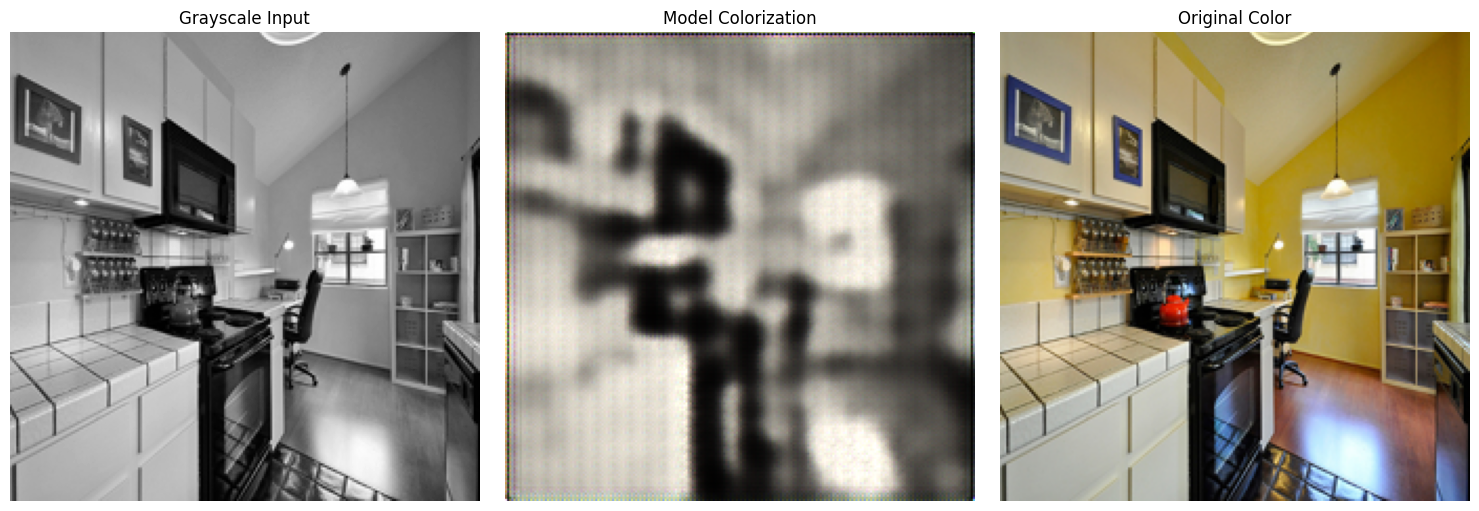

Mean Absolute Error: 0.1291
Visualization complete!


In [2]:
# Set up paths
model_path = os.path.join("models", "colorization_model_resnet50.h5")
data_dir = os.path.join("F:\\ssl_images\\data", "processed", "coco", 'colorization')

# Get a test image path (using the first grayscale image in the directory)
test_image = next(
    os.path.join(data_dir, f) 
    for f in os.listdir(data_dir) 
    if f.startswith("gray")
)
test_image = test_image.replace('_0', '_785')
print(test_image)

print("Running colorization inference...")
visualize_colorization(model_path, test_image)
print("Visualization complete!")

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os


from src.models.resnet import ResNet18, ResNet50

def load_and_preprocess_image(image_path):
    """Load and preprocess a single image for inpainting."""
    # Load image
    img = np.load(image_path)
    
    # Convert to float and normalize
    img = tf.cast(img, tf.float32) / 255.0
    
    # Add batch dimension
    img = tf.expand_dims(img, 0)
    
    return img

def visualize_inpainting(model_path, image_path):
    """Load model, process image, and visualize inpainting results."""
    # Initialize model
    model = ResNet18((224, 224, 3))
    
    # Load trained weights
    model.load_weights(model_path)
    
    # Load and preprocess masked image
    masked_image = load_and_preprocess_image(image_path)
    
    # Get model prediction
    predicted_image = model.predict(masked_image)
    
    # Remove batch dimension
    masked_image = tf.squeeze(masked_image) * 255.0
    predicted_image = tf.squeeze(predicted_image) * 255.0
    
    # Load original image for comparison
    original_path = image_path.replace('masked', 'original')
    original_image = np.load(original_path)
    original_image = original_image.astype(np.float32) #/ 255.0
    
    # Create figure with three subplots
    plt.figure(figsize=(15, 5))
    
    # Plot masked input
    plt.subplot(1, 3, 1)
    plt.imshow(masked_image)
    plt.title('Masked Input')
    plt.axis('off')
    
    # Plot model prediction
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_image)
    plt.title('Inpainted Result')
    plt.axis('off')
    
    # Plot original image
    plt.subplot(1, 3, 3)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print metrics
    mse = tf.reduce_mean(tf.square(original_image - predicted_image))
    mae = tf.reduce_mean(tf.abs(original_image - predicted_image))
    psnr = tf.image.psnr(original_image, predicted_image, max_val=1.0)
    ssim = tf.image.ssim(original_image, predicted_image, max_val=1.0)
    
    print("\nImage Quality Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Peak Signal-to-Noise Ratio: {psnr:.2f} dB")
    print(f"Structural Similarity Index: {ssim:.4f}")
    
    return model

def visualize_multiple_samples(model_path, data_dir, num_samples=5):
    """Visualize multiple inpainting results."""
    # Get list of masked images
    masked_files = [f for f in os.listdir(data_dir) if f.startswith("masked")][:num_samples]
    
    # Load model once
    model = ResNet18((224, 224, 3))
    model.load_weights(model_path)
    
    for masked_file in masked_files:
        print(f"\nProcessing {masked_file}...")
        image_path = os.path.join(data_dir, masked_file)
        
        # Load images
        masked_image = load_and_preprocess_image(image_path)
        predicted_image = model.predict(masked_image) 
        
        original_path = image_path.replace('masked', 'original')
        original_image = np.load(original_path)
        original_image = original_image.astype(np.float32) #/ 255.0
        
        # Remove batch dimensions
        masked_image = tf.squeeze(masked_image) * 255.0
        predicted_image = tf.squeeze(predicted_image) * 255.0
        
        # Visualize
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(masked_image)
        plt.title('Masked Input')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(predicted_image)
        plt.title('Inpainted Result')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print metrics
        psnr = tf.image.psnr(original_image, predicted_image, max_val=1.0)
        ssim = tf.image.ssim(original_image, predicted_image, max_val=1.0)
        print(f"PSNR: {psnr:.2f} dB")
        print(f"SSIM: {ssim:.4f}")


In [5]:

# Example usage in notebook:
model_path = os.path.join("models", "inpainting_model_final.h5")
data_dir = os.path.join("F:\\ssl_images\\data", "processed", "coco", 'inpainting')

# For single image visualization:
test_image = next(
    os.path.join(data_dir, f) 
    for f in os.listdir(data_dir) 
    if f.startswith("masked")
)
model = visualize_inpainting(model_path, test_image)

# For multiple images visualization:
print("\nVisualizing multiple samples...")
visualize_multiple_samples(model_path, data_dir, num_samples=3)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'models\inpainting_model_final.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
from tensorflow.keras.utils import plot_model
from PIL import Image
import os
import tensorflow as tf
from tqdm import tqdm
import sys

from src.models.resnet import ResNet18, ResNet50  # Import your ResNet implementation

def initialize_model(input_shape):
    """Initialize the ResNet model."""
    return ResNet50(input_shape)

def generate_sample_data(batch_size=4, img_size=(224, 224), channels=3):
    """Generate a batch of random images."""
    return tf.random.uniform((batch_size, *img_size, channels), minval=0, maxval=1)

def test_and_plot(model, batch_size=4, img_size=(224, 224), channels=3):
    """Test the model and plot the results."""
    input_data = generate_sample_data(batch_size=batch_size, img_size=img_size, channels=channels)
    
    # Build the model by running a sample input through it
    sample_input = tf.keras.Input(shape=(img_size[0], img_size[1], channels))
    _ = model(sample_input)

    # Plot the model architecture and save it as an image
    plot_model(model, to_file="resnet_model_architecture.png", show_shapes=True, expand_nested=True)

    # Get model output
    output_data = model(input_data)

    # Save input and output images
    os.makedirs("output_images", exist_ok=True)  # Create directory for output images
    for i in range(batch_size):
        # Save input image
        input_image = (input_data[i].numpy() * 255).astype('uint8')  # Convert to uint8 for saving
        plt.imsave(f"output_images/input_image_{i}.png", input_image)

        # Save output image
        output_image = (output_data[i].numpy() * 255).astype('uint8')  # Convert to uint8 for saving
        plt.imsave(f"output_images/output_image_{i}.png", output_image)

def load_model_weights(model, save_path):
    """Load model weights from the specified path."""
    model.load_weights(save_path)
    print(f"Model weights loaded from {save_path}")


# Test RGB images with 3 channel ResNet
model_rgb = initialize_model((224, 224, 3))  # RGB
test_and_plot(model_rgb, batch_size=4, img_size=(224, 224), channels=3)

# Test grayscale images with 1 channel ResNet
#model_gray = initialize_model((224, 224, 1))  # Grayscale
#test_and_plot(model_gray, batch_size=4, img_size=(224, 224), channels=1)

#model_load = initialize_model((224, 224, 1))
                                    


In [5]:
from src.models.experimental_resnet import ResNet18, ResNet50  # Import your ResNet implementation

model = ResNet50((224, 224, 3))
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 64)      9472      
                                                                 
 bn1 (BatchNormalization)    (None, 112, 112, 64)      256       
                                                                 
 re_lu_34 (ReLU)             (None, 112, 112, 64)      0         
                                                                 
 block_0_0 (ResNetBlock)     (None, 56, 56, 64)        78784     
                                                                 
 block_0_1 (ResNetBlock)     (None, 56, 56, 64)        74368     
                                                                 
 block_0_2 (ResNetBlock)     (None, 56, 56, 64)        743

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

# Carregar o modelo ResNet50 com pesos pré-treinados
model = ResNet50()

# Imprimir o resumo do modelo
model.summary()


KeyboardInterrupt: 